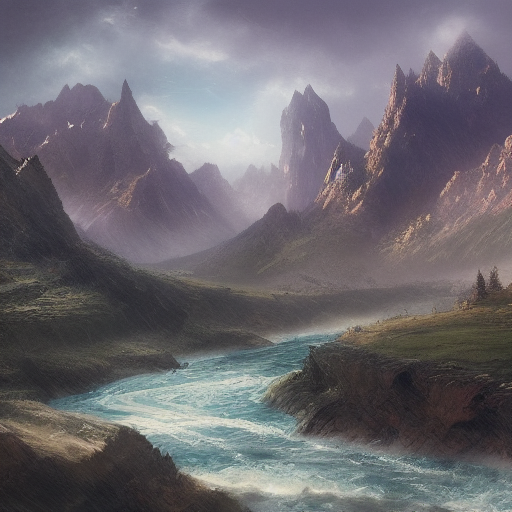

In [6]:
import requests
from PIL import Image
from io import BytesIO
import base64
from IPython.display import display

# Send request
url = "http://localhost:7860/sdapi/v1/txt2img"
payload = {
    "prompt": "A fantasy landscape with mountains and rivers in the style of Greg Rutkowski",
    "steps": 20
}
response = requests.post(url, json=payload)
result = response.json()

# Decode the image
image_base64 = result['images'][0]
image_bytes = base64.b64decode(image_base64)
image = Image.open(BytesIO(image_bytes))

# Display inline in Jupyter
display(image)


In [60]:
question = input()


In [79]:
def get_prompt(question):
    url = "http://localhost:1234/v1/chat/completions"
    headers = {"Content-Type": "application/json"}

    system_prompt = """You are a helpful AI Assistant.
    You write prompts for Stable Diffusion image generation focused exclusively on food as the main subject. Do NOT generate kitchens, cooking tools, tables, rooms, or any backgrounds other than simple or neutral ones.
    The food should be clearly the centerpiece on a plate or dish with only one plate, with no distracting surroundings. Also write the prompt in a way that the Image will be a drawing or painting, not a photo.

    Always follow this format for Stable Diffusion prompting:

    Positive prompt: Describe clearly what to generate, including style, colors, objects, environment (simple or neutral backgrounds only), mood, etc.

    Format example:

    Positive prompt: a detailed painting of a futuristic city at sunset, vibrant colors, ultra-realistic

    For prompting:"""

    data = {
        "model": "qwen3-0.6b",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        "temperature": 0.1,
        "max_tokens": 1024,
        "stream": False
    }

    response = requests.post(url, headers=headers, json=data)
    answer = response.json()["choices"][0]["message"]["content"].strip()

    if "</think>" in answer:
        clean_answer = answer.split("</think>")[-1].strip()
    else:
        clean_answer = answer.strip()

    print(clean_answer)

    prompt = clean_answer.replace("Positive prompt:", "").strip()
    return prompt


In [81]:
# Send request
def create_image(prompt): 
    url = "http://localhost:7860/sdapi/v1/txt2img"
    payload = {
        "prompt": prompt,
        "negative_prompt": "blurry, low resolution, watermarks, text, logo, signature, bad anatomy, bad hands, bad proportions, ugly, duplicate, morbid, mutilated, out of frame, extra digit, fewer digits, cropped, worst quality, low quality",
        "steps": 30,
        "cfg_scale": 7,
        "width": 1024,
        "height": 512,
        "sampler_name": "Euler a",  # or "DPM++ 2M Karras", etc.
        "seed": -1  # -1 means random
    }

    response = requests.post(url, json=payload)
    result = response.json()

    # Decode the image
    image_base64 = result['images'][0]
    image_bytes = base64.b64decode(image_base64)
    image = Image.open(BytesIO(image_bytes))

    # Display inline in Jupyter
    # display(image)
    return image



In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained(model_name)

def compute_similarity(image: Image.Image, text: str) -> float:
    inputs = processor(text=[text], images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    similarity = torch.matmul(text_embeds, image_embeds.T).item()
    return similarity


c:\Users\TimPr\allcode\FHCode-1\genv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\TimPr\allcode\FHCode-1\genv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TimPr\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to acti

In [ ]:
# Spinach kitchen
similarity_score = compute_similarity(image, question)
print(f"Similarity: {similarity_score:.4f}")

Similarity: 0.1926


In [ ]:
# Schnitzel
similarity_score = compute_similarity(image, question)
print(f"Similarity: {similarity_score:.4f}")

Similarity: 0.2769


In [ ]:
# Hochzeitssuppe
similarity_score = compute_similarity(image, question)
print(f"Similarity: {similarity_score:.4f}")

Similarity: 0.2707


In [57]:
# Klöße
similarity_score = compute_similarity(image, question)
print(f"Similarity: {similarity_score:.4f}")

Similarity: 0.2211


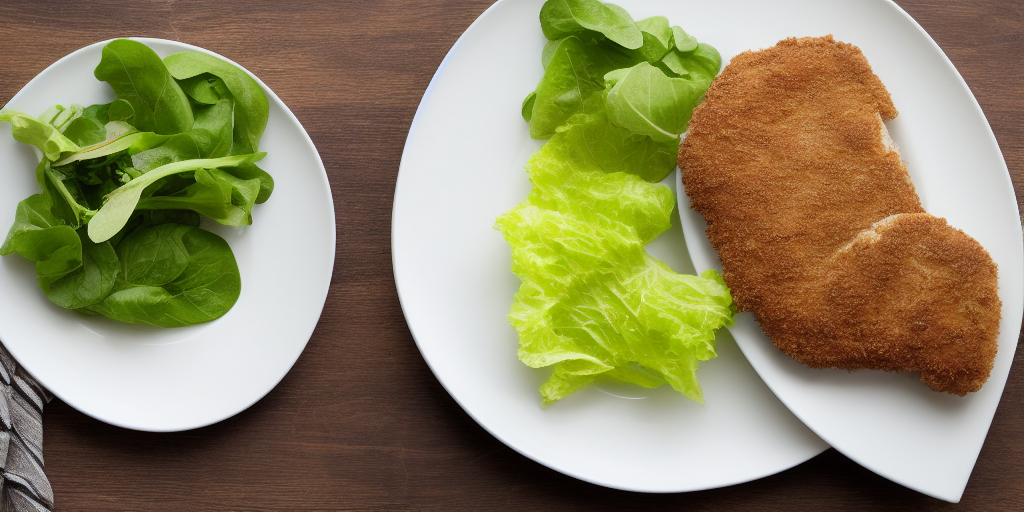

Iteration 1 - Similarity: 0.2785


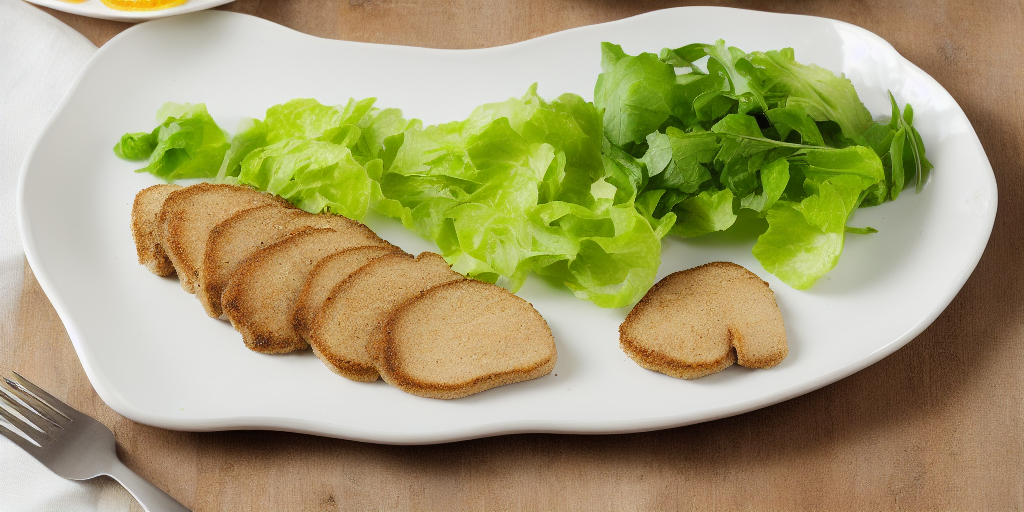

Iteration 2 - Similarity: 0.2530


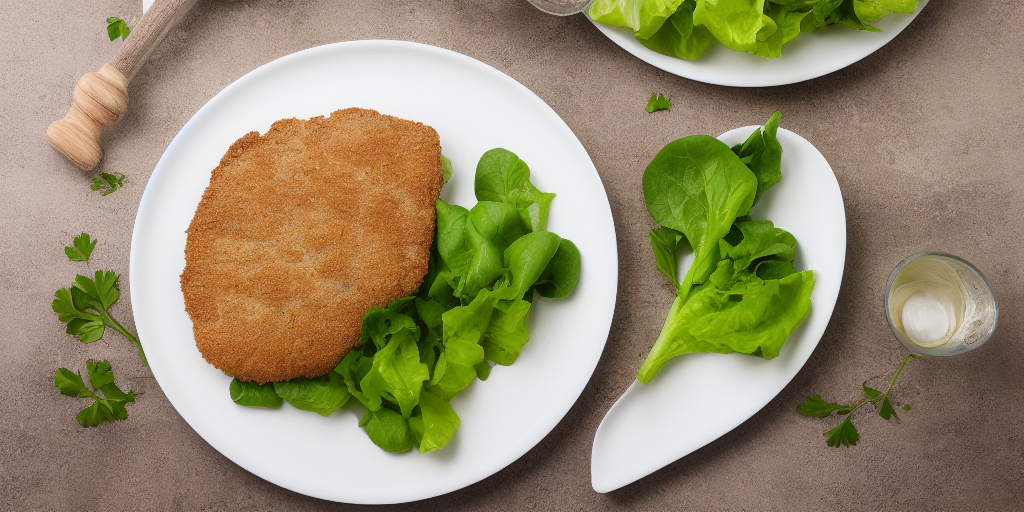

Iteration 3 - Similarity: 0.2919
Best image based on similarity score:


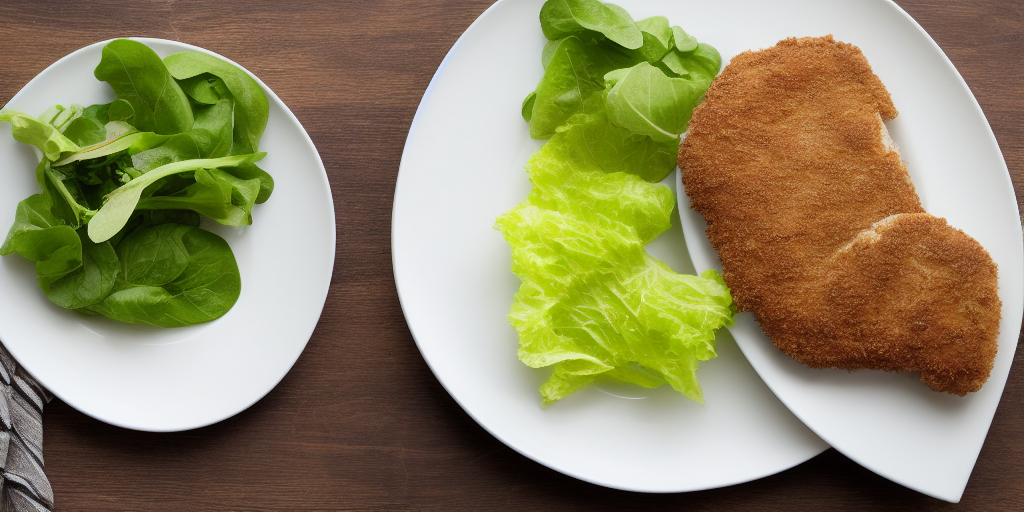

In [72]:
# Pipeline
similarity_scores = []
images = []
for i in range(3):
    image = create_image(prompt)
    similarity_score = compute_similarity(image, question)
    print(f"Iteration {i+1} - Similarity: {similarity_score:.4f}")
    similarity_scores.append(similarity_score)
    images.append(image)

similarity_scores.sort(reverse=True)
best_image = images[similarity_scores.index(max(similarity_scores))]
print("Best image based on similarity score:")
display(best_image)

    

In [82]:
# Pipeline
def pipeline(question):
    prompt = get_prompt(question)
    similarity_scores = []
    images = []
    for i in range(3):
        image = create_image(prompt)
        similarity_score = compute_similarity(image, question)
        print(f"Iteration {i+1} - Similarity: {similarity_score:.4f}")
        similarity_scores.append(similarity_score)
        images.append(image)

    similarity_scores.sort(reverse=True)
    best_image = images[similarity_scores.index(max(similarity_scores))]
    print("Best image based on similarity score:")
    display(best_image)

    

Positive prompt: a detailed painting of a steaming plate with a single steak on it, surrounded by simple elements like a knife and fork, with a neutral background and warm colors to evoke warmth and simplicity.
Iteration 1 - Similarity: 0.2701
Iteration 2 - Similarity: 0.2868
Iteration 3 - Similarity: 0.2829
Best image based on similarity score:


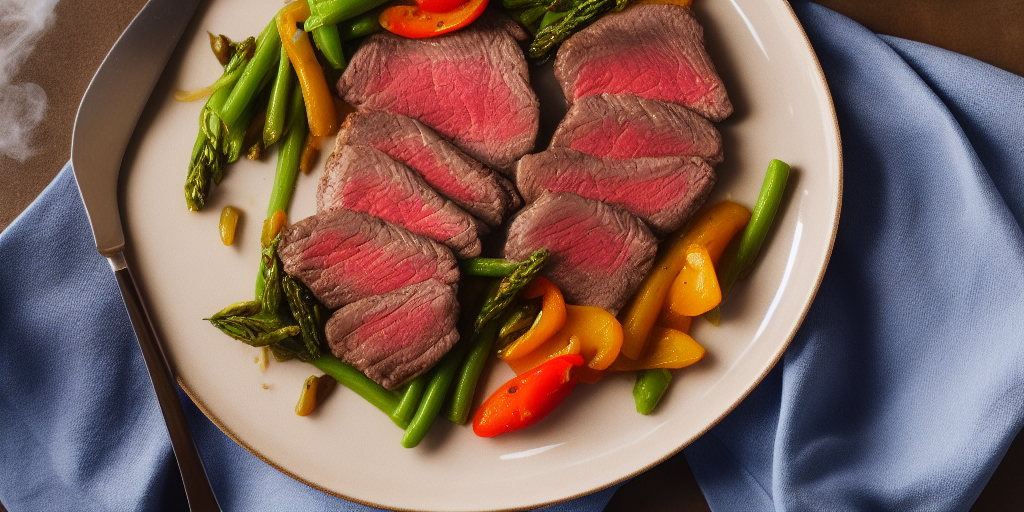

In [ ]:
pipeline("")